<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.6 MB/s eta 0:00:00


In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "mogvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/mogvae_models.py",
    "vqvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vqvae_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
mogvae_models.py downloaded successfully.
vqvae_models.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import mogvae_models
import vqvae_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data
from mogvae_models import MoGVAE
from vqvae_models import VQVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.91 GB


In [9]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data(file_names, num_points=num_points, device=device)
print(len(data_loader))
# VQ-VAEモデル構築
vae = VQVAE(n_in_out=3 * num_points, embedding_dim=3, num_embeddings=1024).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

9


In [12]:
z_list = None  # z_list を初期化
epochs = 5000
n_in_out = 3 * num_points
interval = 100

rec_error_record = []
reg_error_record = []
total_error_record = []
for i in range(epochs):
    vae.train()
    loss_rec = 0
    loss_reg = 0
    loss_total = 0

    for k, (x,) in enumerate(data_loader):
        # xをdeviceに移動
        x = x.to(device)

        # xの形状を (batch_size, channels, sequence_length) に変換
        x = x.view(1, n_in_out, 1)  # 1バッチ、チャンネル数 `n_in_out`、シーケンス長 1

        # VAEの出力と損失を計算
        y, quantization_loss, z, embedding_dim = vae(x)  # embedding_dimを取得
        lrec = F.mse_loss(y, x)  # 再構成損失

        # 損失の合計を計算
        loss = lrec + quantization_loss
        loss_rec += lrec.item()
        loss_reg += quantization_loss.item()
        loss_total += loss.item()

        # 最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 最終エポックでz_listを保存
        if i == epochs - 1:
            z_np = z.cpu().detach().numpy()
            if z_list is None:
                z_list = z_np  # 初回のみ初期化
            else:
                if z_list.shape[1] == z_np.shape[1]:  # shape[1] (embedding_dim) が一致する場合のみ結合
                    z_list = np.vstack((z_list, z_np))
                else:
                    print(f"Shape mismatch: z_list.shape={z_list.shape}, z_np.shape={z_np.shape} — Skipping this batch.")

    # 平均を計算
    loss_rec /= (k + 1)
    loss_reg /= (k + 1)
    loss_total /= (k + 1)

    # ログの記録
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    # 指定間隔でのログ出力
    if i % interval == 0:
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

# 最終エポック後に z_list を保存
if z_list is not None:
    np.save("z_list_final.npy", z_list)
    print(f"z_list saved with shape: {z_list.shape}")


    # 平均を計算
    loss_rec /=  (k + 1)
    loss_reg /=  (k + 1)
    loss_total /=  (k + 1)

    # ログの記録
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    # 指定間隔でのログ出力
    if i % interval == 0:
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

# z_listを結合
z_list = np.concatenate(z_list, axis=0)


Epoch:0 Loss_Rec:0.25246193011601764 Loss_Reg:0.0576308849785063 Loss_Total:0.31009281675020856
Epoch:100 Loss_Rec:0.07610598040951623 Loss_Reg:0.00046913944808895595 Loss_Total:0.07657511946227816
Epoch:200 Loss_Rec:0.07667322125699785 Loss_Reg:6.260661424069743e-05 Loss_Total:0.07673582765791151
Epoch:300 Loss_Rec:0.05554499684108628 Loss_Reg:4.1471309815379856e-05 Loss_Total:0.05558646801445219
Epoch:400 Loss_Rec:0.05311769660976198 Loss_Reg:5.26012308404865e-05 Loss_Total:0.05317029791573683
Epoch:500 Loss_Rec:0.040074760026376076 Loss_Reg:3.8959942811642475e-05 Loss_Total:0.0401137202214967
Epoch:600 Loss_Rec:0.03248408249217189 Loss_Reg:7.542770350078677e-05 Loss_Total:0.03255951021694475
Epoch:700 Loss_Rec:0.03894942125771195 Loss_Reg:4.639456255972618e-05 Loss_Total:0.03899581613950431
Epoch:800 Loss_Rec:0.01982752503762539 Loss_Reg:7.583256127771974e-05 Loss_Total:0.019903357590212382
Epoch:900 Loss_Rec:0.017727245573445946 Loss_Reg:0.00019269057560854385 Loss_Total:0.01791993

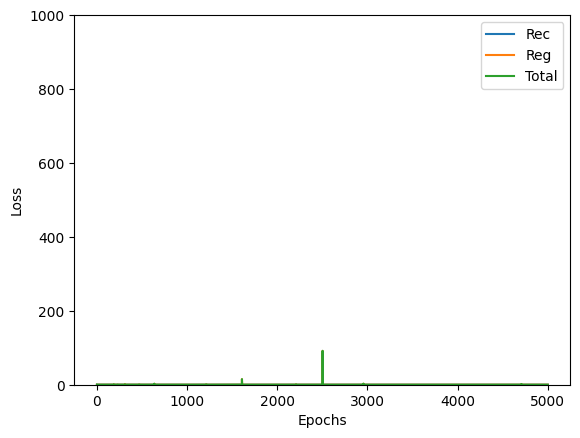

Model weights have been saved!


In [13]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/VQVAE_Np5000_MSE_0216.pth')
print("Model weights have been saved!")

In [15]:
print(z_list) # z mu logvar

[tensor([ 0.3161, -0.2567,  0.3267], device='cuda:0'), tensor([-0.4071,  0.1210, -0.0652], device='cuda:0'), tensor([-0.1449, -0.0818,  0.1165], device='cuda:0'), tensor([ 0.5800, -0.1102,  0.2293], device='cuda:0'), tensor([ 0.5863,  0.1243, -0.0343], device='cuda:0'), tensor([ 0.2728,  0.2105, -0.1344], device='cuda:0'), tensor([-0.0697,  0.4417, -0.3713], device='cuda:0'), tensor([-0.0810,  0.1481, -0.1027], device='cuda:0'), tensor([-0.1842, -0.4170,  0.3917], device='cuda:0')]


# 再構成形状の可視化

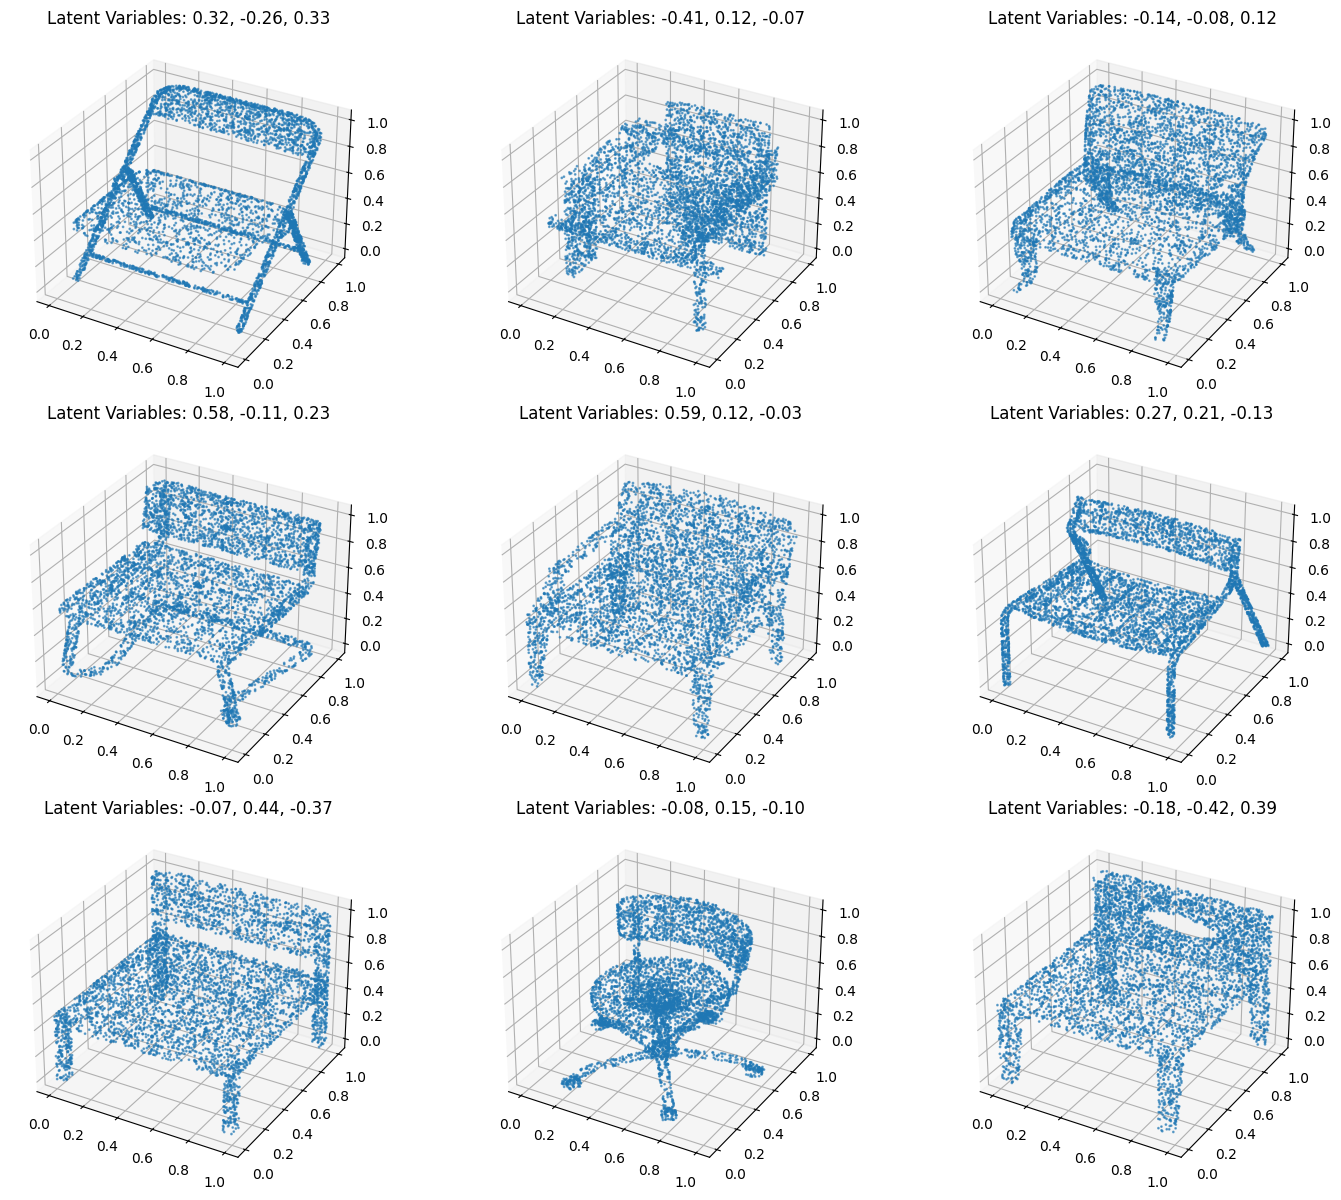

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    in_z = z.unsqueeze(0)  # (64,) -> (1, 64)
    recon_batch = vae.decode(in_z)
    # 再構築 (z を 1バッチの形に変換して decode)
    #recon_batch = vae.decode(z)  # z をバッチの形状に変換

    # CPU上で detach して numpy に変換
    reconst = recon_batch.cpu().detach().numpy().reshape(-1)

    # num_points に基づいて点群を分割
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

Chamfer Distances: [0.20015652477741241, 0.16223391890525818, 0.18745386600494385, 0.16600465774536133, 0.17673936486244202, 0.22841550409793854, 0.2039835900068283, 0.20839513838291168, 0.19181856513023376]
Average Chamfer Distance: 0.19168901443481445


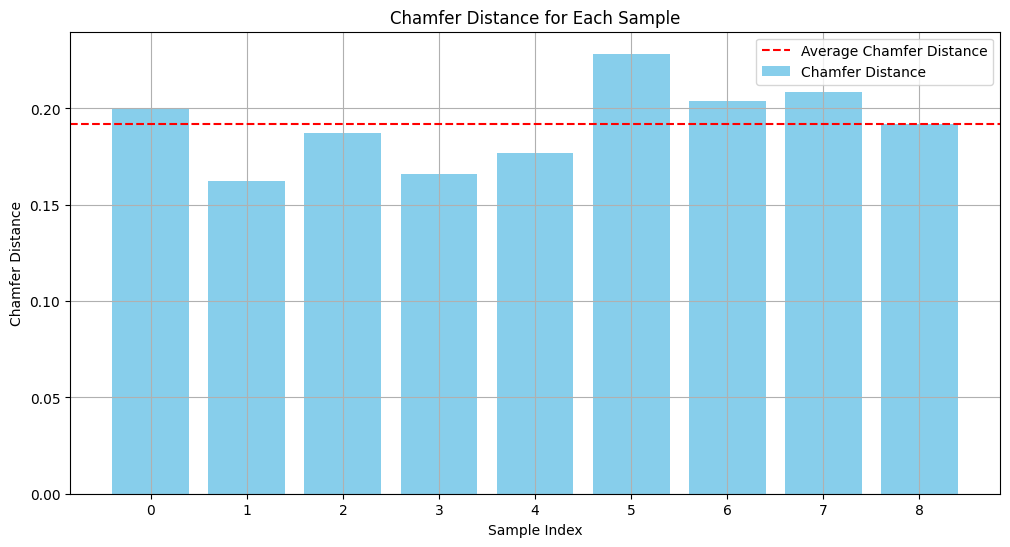

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Chamfer Distanceの計算
chamfer_distances = []
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    in_z = z.unsqueeze(0)  # (64,) -> (1, 64)
    recon_batch = vae.decode(in_z)

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

EMD Distances: [0.22101371140135778, 0.18317198410528712, 0.20432990839993753, 0.18641792565508622, 0.19959855407386953, 0.23504855745714903, 0.21058147926320264, 0.23440542294495087, 0.22683840507169464]
Average EMD Distance: 0.21126732759694838


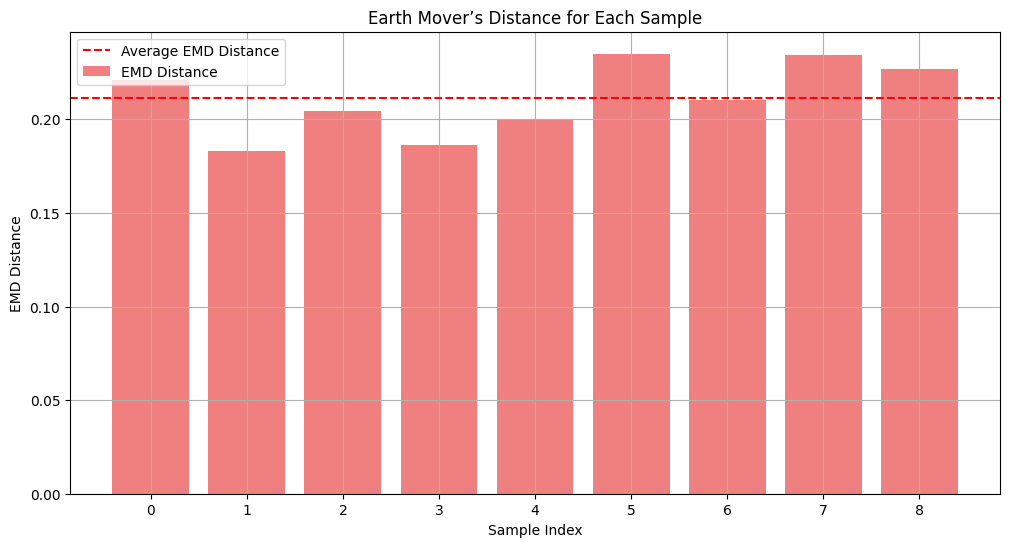

In [20]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    in_z = z.unsqueeze(0)  # (64,) -> (1, 64)
    recon_batch = vae.decode(in_z)

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
